# Planning a telescope observation

You are a real astronomer (not a theory guy like me) and are planning an expensive observational campaign. You want to know how likely it is that tomorrow night will be clear given the weather tonight (clear or cloudy). The key piece of information here is that the weather tomorrow depends on the weather today. From past history, you know that:

$$p(\rm clear \ tomorrow| \rm \ cloudy \ today) = 0.5$$

which means that $$p(\rm cloudy \ today| \rm \ cloudy \ tomorrow) = 0.5$$

We also have $$p(\rm cloudy \ tomorrow| \rm \ clear \ today) = 0.1$$

which means that $$p(\rm clear \ tomorrow| \rm \ clear \ today) = 0.5$$

- We can start with the sky conditions today and make predictions going forward more and more into the future.
- This will look like a big decision tree.
- After enough days, we'll reach equilibrium probabilities that have to do with the mean weather statistics (ignoring seasons) and we'll arrive at $p(\rm clear) = 0.83$ and $p(\rm cloudy) = 0.17$.

You get the same answer for day $N$ as day $N + 1$ and it doesn't matter whether it was clear or cloudy on the day that you started. The steps that we have taken in this process are, indeed, a **MARKOV CHAIN**.

Here is an illustration of this process:

![image.png](https://miro.medium.com/max/416/1*frksGjINf5oTjx7WL81U3w.png)

**Tasks**:
- Start off on a cloud day.
- Implement your weather forecast based on the above probabilities
- Run your simulator for N days (with $N \gtrsim 10^4$)
- Prepare a plot with the number of days on the x axis and the cumulative fraction of, say, sunny days over the number of days so far on the y axis. This is called a **trace-plot**, showing how our estimate of $p(clear)$ evolves as the chain samples.
- Prepare a histogram of the above plot. This reveals the distribution of $p(clear)$ .
- Use a summary statistics to determine the most likely value and an error on our estimate.

**Important**:
- In MCMC the process must be **stationary** which basically means that the chain statistics look the same no matter which chunk you look at, e.g. first half, second half, or every other point, etc.
- Obviously that isn't going to be the case in the early steps of the chain. In our example above, after some time the process was stationary, but not in the first few days.
- So, there is a **burn-in** phase that needs to be discarded. How one determines the number of early steps to discard as burn-in is tricky, ***but you should always start with a traceplot of your samples!***

**Tasks**
- In the above example, experiment with chopping off different numbers of initial points as burn-in.

**(Optional, not examinable) Finance**
- Redo the same for the Markovian process describing the stock market (see above in this notebook). If you've written your code well, this should require minor modifications.

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import astroML.stats as astroMLstats
from astropy.visualization import hist

In [45]:
# Define probality
p_cloudy_att = 0.17
p_clear_att = 0.83

p_clear_from_cloudy = 0.5   # p(clear tomorrow | cloudy today)
p_cloudy_from_cloudy = 0.5  # p(cloudy tomorrow | cloudy today)
p_cloudy_from_clear = 0.1   # p(cloudy tomorrow | clear today)
p_clear_from_clear = 0.9    # p(clear tomorrow | clear today)

# Weather states
cloudy = 0
clear = 1

# Number of iterations
N = 100000

# Random number generator
rng = np.random.default_rng()

In [46]:
def forecast(today, p_cloudy_from_cloudy, p_cloudy_from_clear):
    if today == cloudy: #today cloudy
        if rng.uniform() < p_cloudy_from_cloudy:
            return cloudy
        else: 
            return clear
    if today == clear: #today clear
        if rng.uniform() < p_cloudy_from_clear:
            return cloudy
        else: 
            return clear

## Trace-plot

In [47]:
# Define starting condition
today = cloudy

# Inizialize the Markov Chain
days = np.array([])
days = np.append(days, today)

p_clear = []
p_cloudy = []

for i in range(1, N+1):
    tomorrow = forecast(days[i-1], p_cloudy_from_cloudy, p_cloudy_from_clear)
    
    days = np.append(days, tomorrow)

# Probability for each day
N_days = np.arange(N + 1)
p_clear = np.cumsum(days == clear) / (N_days + 1)
p_cloudy = np.cumsum(days == cloudy) / (N_days + 1)

print("Clear day: " + str(np.count_nonzero(days == clear)))
print("Cloudy day: " + str(np.count_nonzero(days == cloudy)))

print(f"Total Probability of clear day: {np.count_nonzero(days == clear) / len(days):.3f}")
print(f"Total Probability of cloudy day: {np.count_nonzero(days == cloudy) / len(days):.3f}")

Clear day: 83034
Cloudy day: 16967
Total Probability of clear day: 0.830
Total Probability of cloudy day: 0.170


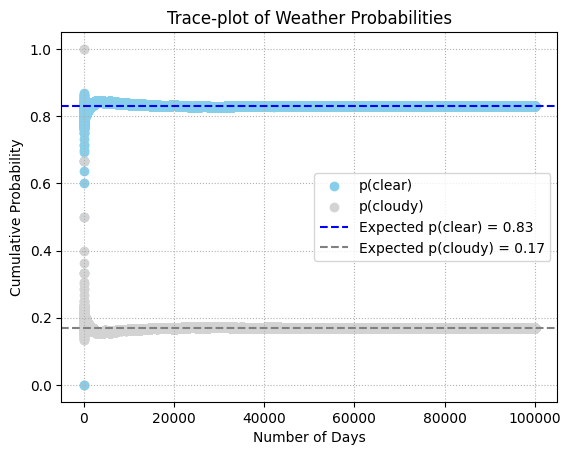

In [48]:
# Trace plot
plt.scatter(N_days, p_clear, color='skyblue', label='p(clear)')
plt.scatter(N_days, p_cloudy, color='lightgray', label='p(cloudy)')
plt.axhline(p_clear_att, color='blue', linestyle='--', label=f'Expected p(clear) = {p_clear_att}')
plt.axhline(p_cloudy_att, color='gray', linestyle='--', label=f'Expected p(cloudy) = {p_cloudy_att}')
plt.title('Trace-plot of Weather Probabilities')
plt.xlabel('Number of Days')
plt.ylabel('Cumulative Probability')
plt.legend()
plt.grid(linestyle=':')
plt.show()

### Histogram of cumulative probabilities

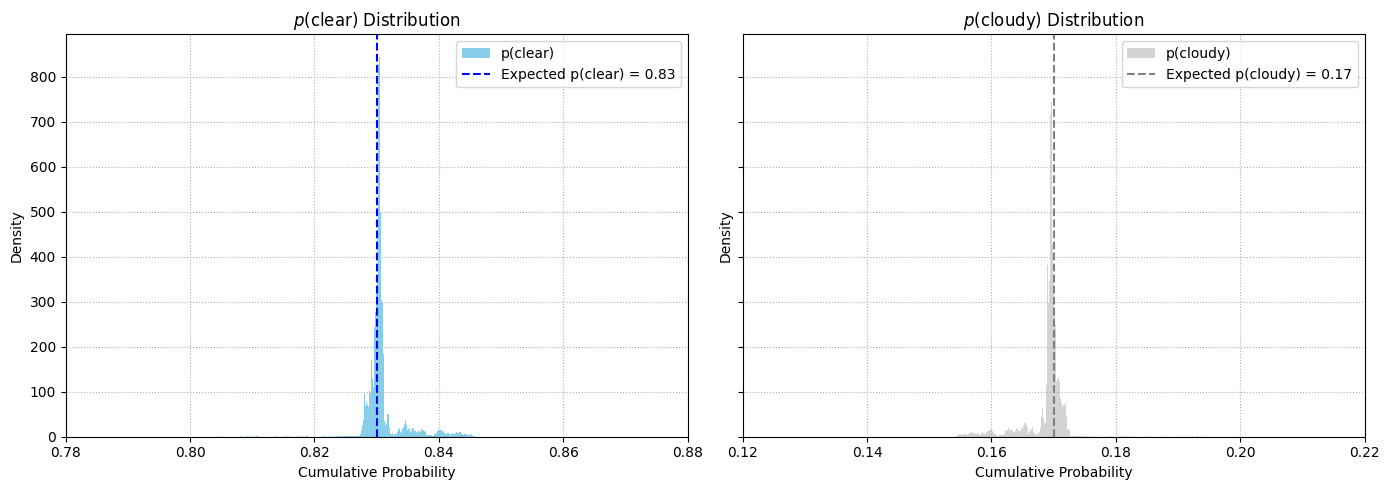

In [49]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# Histogram for p(clear)
hist(p_clear, bins='freedman', density=True, color='skyblue', label = 'p(clear)', ax=axes[0])
axes[0].axvline(p_clear_att, color='blue', linestyle='--', label=f'Expected p(clear) = {p_clear_att}')
axes[0].set_title('$p(\\mathrm{clear})$ Distribution')
axes[0].set_xlabel('Cumulative Probability')
axes[0].set_ylabel('Density')
axes[0].set_xlim(0.78, 0.88)
axes[0].legend()
axes[0].grid(linestyle=":")

# Histogram for p(cloudy)
hist(p_cloudy, bins='freedman', density=True, color='lightgray', label = 'p(cloudy)', ax=axes[1])
axes[1].axvline(p_cloudy_att, color='gray', linestyle='--', label=f'Expected p(cloudy) = {p_cloudy_att}')
axes[1].set_title('$p(\\mathrm{cloudy})$ Distribution')
axes[1].set_xlabel('Cumulative Probability')
axes[1].set_ylabel('Density')
axes[1].set_xlim(0.12, 0.22)
axes[1].legend()
axes[1].grid(linestyle=":")

plt.tight_layout()
plt.show()

### Summary statistics

In [50]:
m_clear = np.median(p_clear)
err_m_clear = astroMLstats.sigmaG(p_clear)

m_cloudy = np.median(p_cloudy)
err_m_cloudy = astroMLstats.sigmaG(p_cloudy)

print("Full trace summary statistics:")
print(f" p(clear)  = {m_clear:.4f} ± {err_m_clear:.4f}")
print(f" p(cloudy) = {m_cloudy:.4f} ± {err_m_cloudy:.4f}")

Full trace summary statistics:
 p(clear)  = 0.8304 ± 0.0007
 p(cloudy) = 0.1696 ± 0.0007


## Burn-in analysis

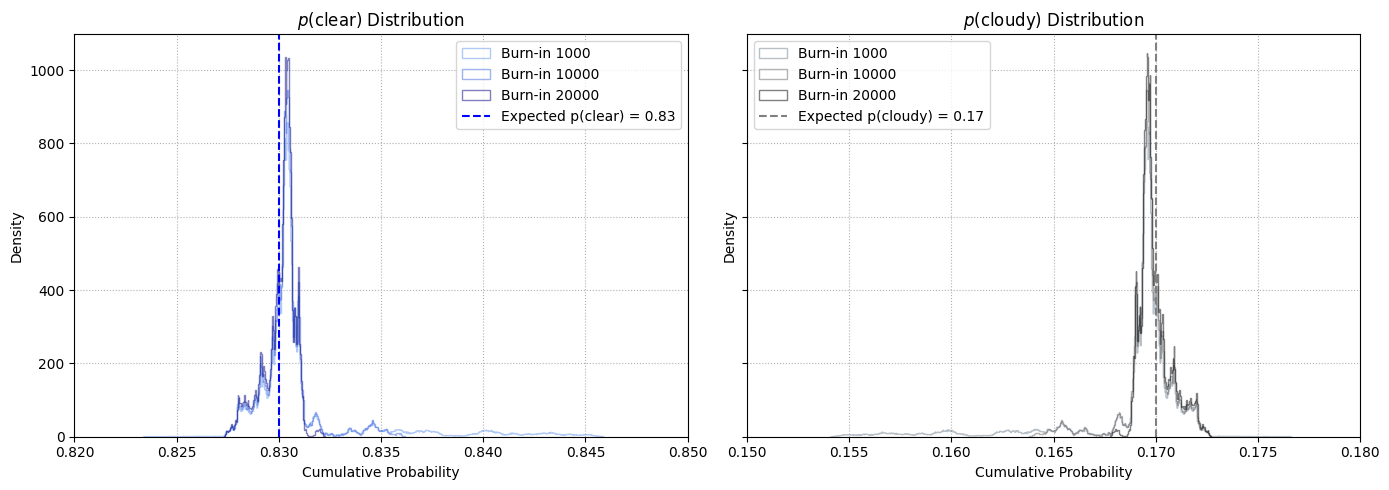

Summary Statistics 

 Burn-in 1000:
   p(clear)  = 0.8304 ± 0.0007
   p(cloudy) = 0.1696 ± 0.0007

 Burn-in 10000:
   p(clear)  = 0.8303 ± 0.0006
   p(cloudy) = 0.1697 ± 0.0006

 Burn-in 20000:
   p(clear)  = 0.8303 ± 0.0006
   p(cloudy) = 0.1697 ± 0.0006



In [51]:
# Histograms with different burns
burns = [1000, 10000, 20000]
labels = [f'Burn-in {burn}' for burn in burns]
colors_clear = ['cornflowerblue', 'royalblue', 'navy']
colors_cloudy = ['slategray', 'dimgray', 'black']

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# p(clear)
for burn, color, label in zip(burns, colors_clear, labels):
    hist(p_clear[burn:], bins='freedman', density=True, alpha = 0.5, histtype='step', color=color, label = label, ax=axes[0])
axes[0].axvline(p_clear_att, color='blue', linestyle='--', label=f'Expected p(clear) = {p_clear_att}')
axes[0].set_title('$p(\\mathrm{clear})$ Distribution')
axes[0].set_xlabel('Cumulative Probability')
axes[0].set_ylabel('Density')
axes[0].set_xlim(0.82, 0.85)
axes[0].legend()
axes[0].grid(linestyle=":")

# p(cloudy)
for burn, color, label in zip(burns, colors_cloudy, labels):
    hist(p_cloudy[burn:], bins='freedman', density=True, alpha = 0.5, histtype='step', color=color, label = label, ax=axes[1])
axes[1].axvline(p_cloudy_att, color='gray', linestyle='--', label=f'Expected p(cloudy) = {p_cloudy_att}')
axes[1].set_title('$p(\\mathrm{cloudy})$ Distribution')
axes[1].set_xlabel('Cumulative Probability')
axes[1].set_ylabel('Density')
axes[1].set_xlim(0.15, 0.18)
axes[1].legend()
axes[1].grid(linestyle=":")

plt.tight_layout()
plt.show()

# Summary statisitc
print("Summary Statistics \n")
for burn in burns:
    med_clear = np.median(p_clear[burn:])
    err_clear = astroMLstats.sigmaG(p_clear[burn:])
    med_cloudy = np.median(p_cloudy[burn:])
    err_cloudy = astroMLstats.sigmaG(p_cloudy[burn:])
    print(f" Burn-in {burn}:")
    print(f"   p(clear)  = {med_clear:.4f} ± {err_clear:.4f}")
    print(f"   p(cloudy) = {med_cloudy:.4f} ± {err_cloudy:.4f}\n")

## Optional: Finance

This would a a Marov Chain model:
<div style="background-color: white; display: table; width: max-content;">
  <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/9/95/Finance_Markov_chain_example_state_space.svg/400px-Finance_Markov_chain_example_state_space.svg.png" alt="Markov Chain">
</div>



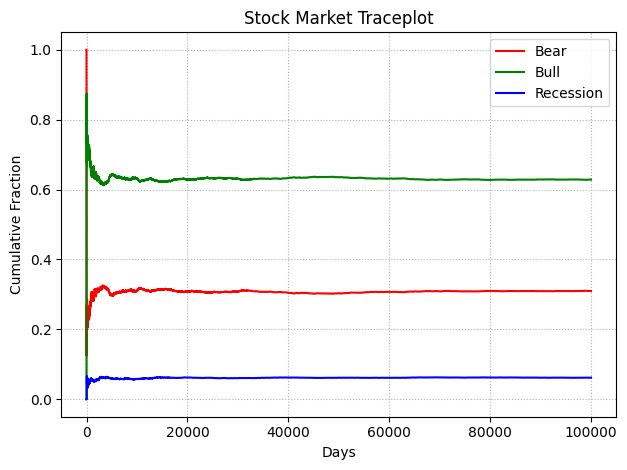

In [54]:
# Transition matrix
P = np.array([
    [0.8, 0.15, 0.05],    # Bear - decreasing prices
    [0.075, 0.9, 0.025],  # Bull - growing prices
    [0.25, 0.25, 0.5],    # Stagnant
])

# Simulation parameters
N = 100000
rng = np.random.default_rng()

# Initial state
current_state = 0  # Start in Bear market
states = [current_state]

# Run the Markov Chain
for _ in range(N):
    current_state = rng.choice([0, 1, 2], p=P[current_state])
    states.append(current_state)

states = np.array(states)

# Trace-plot
fraction_bear = np.cumsum(states == 0) / (np.arange(len(states)) + 1)
fraction_bull = np.cumsum(states == 1) / (np.arange(len(states)) + 1)
fraction_recession = np.cumsum(states == 2) / (np.arange(len(states)) + 1)

days = np.arange(len(states))

plt.plot(days, fraction_bear, color='red', label='Bear')
plt.plot(days, fraction_bull, color='green', label='Bull')
plt.plot(days, fraction_recession, color='blue', label='Recession')
plt.title("Stock Market Traceplot")
plt.xlabel("Days")
plt.ylabel("Cumulative Fraction")
plt.legend()
plt.grid(True, linestyle=':')
plt.tight_layout()
plt.show()

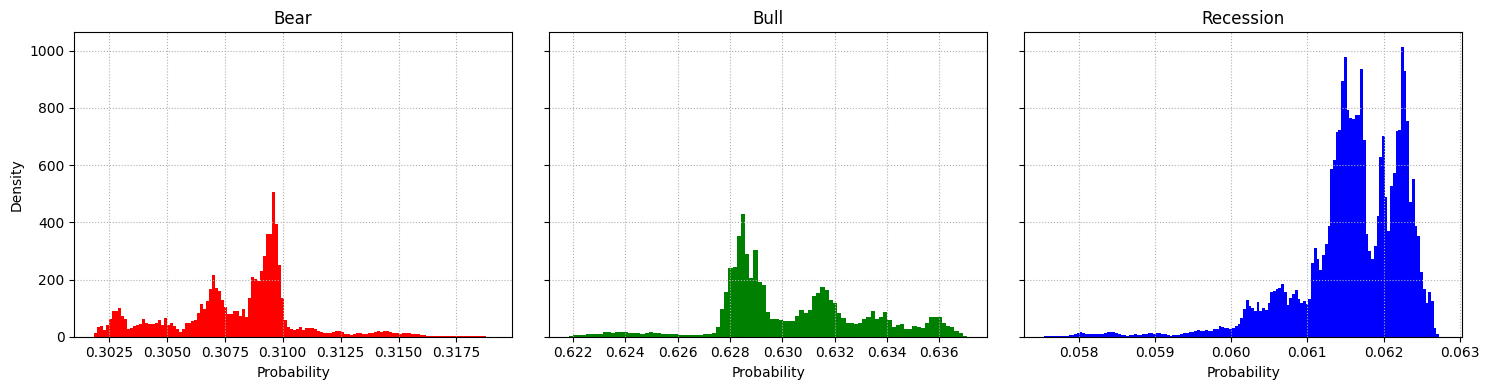

Summary statistics:
 Bear:      0.3087 ± 0.0022
 Bull:      0.6294 ± 0.0027
 Recession: 0.0617 ± 0.0006


In [55]:
burn = 10000  # Burn-in phase
fractions = {
    'Bear': fraction_bear[burn:],
    'Bull': fraction_bull[burn:],
    'Recession': fraction_recession[burn:]
}

fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
colors = ['red', 'green', 'blue']

for ax, (label, data), color in zip(axes, fractions.items(), colors):
    hist(data, bins='freedman', density=True, ax=ax, color=color)
    ax.set_title(label)
    ax.set_xlabel("Probability")
    ax.grid(linestyle=':')

axes[0].set_ylabel("Density")

plt.tight_layout()
plt.show()

# Print Summary Statistics
print("Summary statistics:")
for label, data in fractions.items():
    median = np.median(data)
    sigmaG = astroMLstats.sigmaG(data)
    print(f" {label}:".ljust(12) + f"{median:.4f} ± {sigmaG:.4f}")